# Study of first order Frank Wolfe algorithms to solve constrained non-convex problems in the context of white box adversarial attacks.

Authors: Laia Porcar, Stefanija Galevska, Philippe Robert, Luis M. López

Objectives:

- Implement three Frank Wolfe algorithms for non convex contrained problem.

- Test the algorithms with the MNIST and ImageNet dataset on a whitebox adversarial attack problem. 

# Imports

In [3]:
from keras.datasets import mnist
from matplotlib import pyplot as plt
from numpy import mean
import numpy as np
from numpy import std
from sklearn.model_selection import KFold
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from numpy import random

import tensorflow as tf
from tensorflow.keras import models
import keras
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.imagenet_utils import decode_predictions


import matplotlib.pyplot as plt
import numpy as np
import time

# Dataset and training the neural network

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


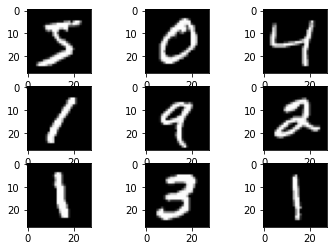

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

# The training set contains 60k images and the testing set contains 10k images.
# The training input vector is of the dimension [60000 X 28 X 28].
# The training output vector is of the dimension [60000 X 1].
# Each individual input vector is of the dimension [28 X 28].
# Each individual output vector is of the dimension [1].

# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [5]:
# Reshape data
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

In [6]:
# one hot encoding of target values
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [7]:
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [8]:
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  
  model.add(Dense(200, activation='relu'))
  model.add(Dense(200, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  
  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [9]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'], label='loss')
  plt.plot(history.epoch,history.history['val_loss'],label='val_loss')
  plt.title('Loss')
  plt.legend(loc=1, prop={'size': 12})
  
def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'],label='accuracy')
  plt.plot(history.epoch,history.history['val_accuracy'],label='val_accuracy')
  plt.title('Accuracy')
  plt.legend(loc=4, prop={'size': 12})

In [10]:
%%time
X_train, X_test = prep_pixels(X_train, X_test)
model = define_model()
history = model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_split = 0.20, verbose=0)

CPU times: total: 1h 3min 52s
Wall time: 7min 33s


313/313 - 2s - loss: 0.0355 - accuracy: 0.9905 - 2s/epoch - 6ms/step
 accuracy: 99.05%


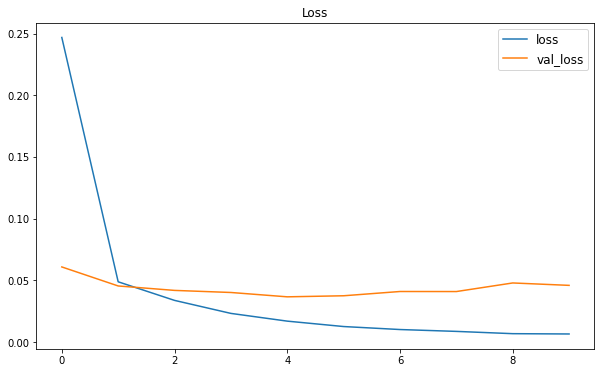

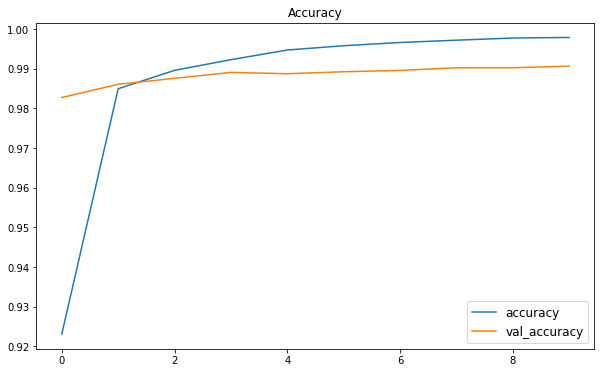

In [11]:
plot_loss(history)
plot_accuracy(history)

scores = model.evaluate(X_test, y_test_cat, verbose=2)
print(" %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# Some functions

In [12]:
def run_classification(input_img, target_label):
    """
    Uses the trained model to classify the image passed and return wether it
    belongs or not to the target class.
       
    Parameters:
    :input_img: (np array): Input image to be classified.
    :target_label: (int): Target class for the attack.

    Returns:
    :target_reached: (boolean) True if the predicted target is the target class.
    :predicted_label: (integer) class that has been predicted.
    """    
    
    # Run the model to predict based on pre-processed image
    predictions_model = model.predict(input_img, verbose = 0)
    
    # Get the predicted label by finding the maximum value
    predicted_label = np.argmax(predictions_model)
    
    # Evaluate if the target label has been reached by comparing        
    target_reached = (target_label == predicted_label)
    
    return target_reached, predicted_label

In [13]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def evaluate_grads(input_img, tgt_class):
  """ 
  Calculates the cross entropy loss and the gradient of the loss with
  respect to the image

  :input_img: (np array) image with respect to which the gradient is calculated.
  :tgt_class: (np array) categorical target class of the attack.

  Returns
  :grad: (tensor) gradient of the loss with respect to the image.
  """
  tgt_class = tgt_class.reshape((1, 10))
  image = tf.Variable(input_img)

  with tf.GradientTape() as gtape:
    gtape.watch(image)
    prediction = model(image)
    loss = loss_object(tgt_class, prediction)

  grads = gtape.gradient(loss, image)
  return grads


def evaluate_grads_sep(input_img, tgt_class, index): 
  """ 
  Calculates the cross entropy loss for one class and the gradient of the loss
   with respect to the image.

  :input_img: (np array) image with respect to which the gradient is calculated.
  :tgt_class: (np array) categorical target class of the attack.
  :index: (int) class for which the cross entropy loss is calculated.

  Returns
  :grads: (tensor) gradient of the loss with respect to the image.
  """
  image = tf.Variable(input_img)

  with tf.GradientTape() as gtape:
    gtape.watch(image)
    prediction = model(image)[0]
    loss = -tgt_class[index] * tf.math.log(prediction[index])

  grads = gtape.gradient(loss, image)
  return grads


In [14]:
def condg(g, u_ori, step, epsilon, eta):
  """ 
  Chooses n_attack images that are classified with an accuracy of 100% by
  the model and randomly creates target classes for those images. 

  Parameters
  :g: (np array) gradient of the loss function with respect to the input image.
  :u_ori: (np array) image to be modified by the function.
  :step: (float) stepsize.
  :epsilon: (float) constraint on the distortion.
  :eta: (float) tolerance.

  Returns
  :u: (np array)  modified image.
  :counter: (int) number of times the linear minimisation oracle is called.
  """

  u_original = np.squeeze(np.copy(u_ori))
  u = np.copy(u_original)
  grad = np.squeeze(np.copy(g))
  inv_step = 1/step
  counter = 0

  while 1:
    counter += 1
    m = grad + inv_step * (u-u_original)
    # Linear Minimisation Oracle
    v_t = - epsilon * np.sign(m) + u_original
    w = v_t - u

    V = np.trace(np.inner(m,-w))

    if V <= eta: 
      return u.reshape((1,28,28,1)), counter

    k = inv_step * (u_original - u) - grad

    numerator = np.trace(np.inner(k, w))
    denominator = inv_step * (np.linalg.norm(w))**2 
    # y2= np.sqrt(np.cumsum(np.square(x), axis=1))
    # denominator = (1/step) * (np.cumsum(np.square(w), axis = 1))**2 
    second_term = numerator/denominator
    alpha = np.minimum(1, second_term)
    u = u + alpha * (v_t-u)

In [15]:
def setup_images(n_attacks, X_test, y_test, y_test_cat):
  """ 
  Chooses n_attack images that are classified with an accuracy of 100% by
  the model and randomly creates target classes for those images. 

  Parameters
  :n_attacks: (int) Number of images to attack.
  :X_test: (np array) test images of MNIST.
  :y_test: (np array) test classes of MNIST.
  :y_test_cat: (np array) categorical test classes of MNIST.

  Returns
  :X_test_attack: (np array)  chosen images to attack
  :random_labels: (np array) randomly generated target classes.
  """

  chosen_index, random_labels = [],[]

  # Randomly choose indices of correctly classified images to attack
  while len(chosen_index) < n_attacks:
    index = np.random.choice(range(len(y_test_cat)), replace = False)
    score = model.evaluate(X_test[index:index+1], 
                           y_test_cat[index:index+1], 
                           verbose=0)
    if score[1] == 1:
      chosen_index.append(index)

  # Extract the images to attack
  X_test_attack = X_test[chosen_index]
  true_labels = y_test[chosen_index]

  # Create random labels
  while len(random_labels) < n_attacks:
    label = random.randint(10)
    if label != true_labels[len(random_labels)]:
      random_labels.append(label)

  return np.array(random_labels), X_test_attack

In [16]:
def launch_attack(random_labels, n_attacks, X_test_attack, func):
  """ 
  Launches the attack of each image at a time storing the new modified image,
  the number of iterations, the distortion and the success boolean.

  Parameters
  :n_attacks: (int) Number of images to attack.
  :random_labels: (np array) randomly generated target classes.
  :X_test_attack: (np array)  chosen images to attack
  :func: name of the algorithm that will perform the attack.
  """
  x_mod, ifo_calls, lmo_calls, distortions, success = [], [], [], [], []
  for i in range(n_attacks):

    image_toattack = np.array(X_test_attack[i:i+1])
    tgt_lab = random_labels[i]

    x_new, ifo, distortion, tgt_reached, lmo = func(image_toattack, tgt_lab)

    x_mod.append(x_new)
    ifo_calls.append(ifo)
    lmo_calls.append(lmo)
    distortions.append(distortion)
    success.append(tgt_reached)

  x_mod = np.array(x_mod)
  x_mod = np.squeeze(x_mod, 1)
  success_rate = 100* sum(success)/len(success)

  print(f"Success rate: {success_rate}%") 
  print("Average number of IFO/SFO calls: ", np.mean(np.array(ifo_calls)))
  print("Average number of LMO calls: ", np.mean(np.array(lmo_calls)))
  # print("Average number of iterations: ", np.mean(np.array(iterations)))
  print("Max distorsion: ", np.mean(distortions))


# FW momentum

In [17]:
def fw_momentum(image_toattack, tgt_lab):
  """ 
  Implements the Frank Wolfe with Momentum algorithm to minimize the loss 
  function of the target class by modifying the original image. 

  Parameters:
  :image_toattack: (np array) image to be attacked.
  :tgt_lab: (int) target class.

  Returns:
  :x: (np array) modified image.
  :lmo_calls: (int) number of times the linar minimisation oracle is called.
  :distortion: L_{inf} norm of the difference between original image and 
  modified image.
  :target_reached: (boolean) True if the attack has been successful and the
  modified image predicts the target class. 
  """
    
  # Hyperparameters
  gamma = 0.45     
  beta = 0.5
  epsilon = 0.3
    
  lmo_calls = 0
  x_ori = np.copy(image_toattack)
  tgt_lab_cat = to_categorical(tgt_lab, 10) 
  x = np.copy(x_ori)

  m = evaluate_grads(x_ori, tgt_lab_cat)


  for iteration in range(30):
      lmo_calls += 1

      # Classify
      target_reached, _ = run_classification(x, tgt_lab)

      if target_reached: break

      # Get gradients
      grad = evaluate_grads(x, tgt_lab_cat)

      m = beta * m + (1-beta) * grad
      v = - epsilon * np.sign(m) + x_ori

      d = v - x
      x = x + gamma * d

  # Calculate distortion
  distortion = np.max(np.abs(x - x_ori))
    
#   if target_reached:
#       print('Attack successful')
        
  return x, lmo_calls * 10, distortion, target_reached, lmo_calls

# FCGS

In [42]:
def fcgs(image_toattack, tgt_lab):
  """ 
  Implements the Faster first order Conditional Gradient Sliding algorithm to
  minimize the loss function of the target class by modifying the original 
  image. 

  Parameters:
  :image_toattack: (np array) image to be attacked.
  :tgt_lab: (int) target class.

  Returns:
  :x_alpha: (np array) modified image.
  :ifo_calls: (int) number times the incremental first order oracle is called.
  :distortion: L_{inf} norm of the difference between original image and 
  modified image.
  :target_reached: (boolean) True if the attack has been successful and the
  modified image predicts the target class. 
  :lmo_calls: (int) number of times the linear minimisation oracle is called.
  """

  # Hyperparameters
  n = 10
  step = 0.03
  eta = 18
  epsilon = 0.3
  ifo_calls = 0
  lmo_calls = 0


  # Implement S2, not as a set of functions, but as the a set 
  # of the numbers corresponding to each function.
  n_S_2 = int(np.ceil(np.sqrt(n))) 
  S_2 = np.random.choice(range(n), n_S_2, replace = False)
  q = len(S_2)

  x_ori = np.copy(image_toattack)
  x_set = [x_ori]
  x = np.copy(x_ori)
  tgt_lab_cat = to_categorical(tgt_lab, 10)


  for k in range(30):
    
    target_reached, _ = run_classification(x, tgt_lab)
    if target_reached: break

    if (k % q) == 0:
      ifo_calls += 10
      v = evaluate_grads(x, tgt_lab_cat)
    else:
      ifo_calls += 2*len(S_2)
      v = (1/q) * sum([evaluate_grads_sep(x, tgt_lab_cat, i) - 
                      evaluate_grads_sep(x_set[-1], tgt_lab_cat, i) + v 
                      for i in S_2])

    x, lmo_call = condg(v, x, step, epsilon, eta)
    x = tf.cast(x, tf.float32)
    x_set.append(x)
    lmo_calls += lmo_call

  # Calculate distortion
  distortion = np.max(np.abs(x - x_ori))
    
  # if target_reached:
  #     print('Attack successful')

  # Randomly choose x_alpha from x_k and return it
  ind = np.random.choice(range(len(x_set))) # but this those doesn't make much sense to me (Luis)
  x_alpha = x_set[ind]
  return x_alpha, ifo_calls, distortion, target_reached, lmo_calls

# NCGS-VR

In [45]:
def ncgs_vr(image_toattack, tgt_lab):  
  """ 
  Implements the Variance Reduction Non-convex Conditional Gradient sSiding
  algorithm to minimize the loss function of the target class by modifying the 
  original image. 

  Parameters:
  :image_toattack: (np array) image to be attacked.
  :tgt_lab: (int) target class.

  Returns:
  :x_alpha: (np array) modified image.
  :ifo_calls: (int) number times the incremental first order oracle is called.
  :distortion: L_{inf} norm of the difference between original image and 
  modified image.
  :target_reached: (boolean) True if the attack has been successful and the
  modified image predicts the target class.
  :lmo_calls: (int) number of times the linear minimisation oracle is called. 
  """

  n = 10
  tol = 1.1
  step = 0.08
  epsilon = 0.3
  ifo_calls = 0
  lmo_calls = 0
  m = int(np.ceil(n**(1/3)))   #iteration length
  b = int(np.ceil(n**(2/3)))   #mini batch size
  T = 100
  S = int(T/m)

  tgt_lab_cat = to_categorical(tgt_lab, 10)
  x_hat = np.copy(image_toattack)
  x_s = np.copy(image_toattack)
  x_set = [x_s]

  for s in range(S):  

    target_reached, _ = run_classification(x_s, tgt_lab)    
    if target_reached: break

    g = (1/n) * sum([evaluate_grads_sep(x_hat, tgt_lab_cat, i) 
                    for i in range(n)])

    for t in range(m):
      I_t = np.random.randint(low=0, high=n, size=b)
      ifo_calls += 2*len(I_t)
      v = g + (1/b) * sum([evaluate_grads_sep(x_s, tgt_lab_cat, j) - 
               evaluate_grads_sep(x_hat, tgt_lab_cat, j) 
               for j in I_t])

      x_s, lmo_call = condg(v, x_s, step, epsilon, tol)  
      x_set.append(x_s)
      lmo_calls += lmo_call
    
    x_hat = x_s    

  # Calculate distortion
  distortion = np.max(np.abs(x_s - image_toattack))
    
  # if target_reached:
  #     print('Attack successful')

  ind = np.random.choice(range(len(x_set)))
  # x_alpha = x_set[ind]
  x_alpha = x_set[-1]
  return x_alpha, ifo_calls, distortion, target_reached, lmo_calls

# **SFW**

In [37]:
def sfw(image_toattack, tgt_lab):
  """ 
  Implements the Stochastic Frank Wolfe algorithm to minimize the loss function
  of the target class by modifying the original image. 

  Parameters:
  :image_toattack: (np array) image to be attacked.
  :tgt_lab: (int) target class.

  Returns:
  :x_alpha: (np array) modified image.
  :lmo_calls: (int) number of times the linear minimisation oracle is called.
  :distortion: L_{inf} norm of the difference between original image and 
  modified image.
  :target_reached: (boolean) True if the attack has been successful and the
  modified image predicts the target class. 
  :ifo_calls: (int) number times the incremental first order oracle is called.
  """
  # Hyperparameters
  epsilon = 0.3    
  step = 0.4
  batch_size = 400 # Let's take fixed batch size
  T = 400

  lmo_calls = 0
  sfo_calls = 0

  tgt_lab_cat = to_categorical(tgt_lab, 10)
  x_ori = np.copy(image_toattack)
  x = np.copy(x_ori)
  x_set = [x_ori]
  all_tuples = [(i,j) for i in range(28) for j in range(28)]

  for t in range(T):
    lmo_calls += 1
    sfo_calls += batch_size
    target_reached, _ = run_classification(x, tgt_lab)
    if target_reached: break

    zetas_ind = np.random.choice(range(28*28), batch_size, replace = False)
    zetas = [all_tuples[i] for i in zetas_ind]

    m = np.zeros((1,28,28,1))
    g = evaluate_grads(x, tgt_lab_cat)

    for index,tupla in enumerate(zetas):
      i, j = tupla
      m[0,i,j,0] = g[0,i,j,0]

  
    m = m * (-1/batch_size)
    v = epsilon * np.sign(m) + x_ori

    d = v - x
    x = x + step * d
    x = tf.cast(x, tf.float32)
    x_set.append(x) 

  # Calculate distortion
  distortion = np.max(np.abs(x - x_ori))
      
  # if target_reached:
  #   print('Attack successful')

  ind = np.random.choice(range(len(x_set)))
  x_alpha = x_set[ind]
  return x_alpha, sfo_calls, distortion, target_reached, lmo_calls

# To run the attack

In [21]:
%%time
n_attacks = 1000
random_labels, X_test_attack = setup_images(n_attacks = n_attacks, 
                                            X_test = X_test, y_test = y_test,
                                            y_test_cat = y_test_cat)

CPU times: total: 39.5 s
Wall time: 36.8 s


In [40]:
%%time
launch_attack(random_labels, n_attacks, X_test_attack, fw_momentum)

Success rate: 99.7%
Average number of IFO/SFO calls:  47.76
Average number of LMO calls:  4.776
Max distorsion:  0.24498962
CPU times: total: 3min 50s
Wall time: 3min 10s


In [43]:
%%time
launch_attack(random_labels, n_attacks, X_test_attack, fcgs)

Success rate: 66.8%
Average number of IFO/SFO calls:  170.912
Average number of LMO calls:  91.595
Max distorsion:  0.29316637
CPU times: total: 41min 18s
Wall time: 27min 51s


In [44]:
%%time
launch_attack(random_labels, n_attacks, X_test_attack, ncgs_vr)

Success rate: 73.8%
Average number of IFO/SFO calls:  601.47
Average number of LMO calls:  416.71
Max distorsion:  0.29096627
CPU times: total: 3h 31min
Wall time: 2h 5min 43s


In [39]:
%%time
launch_attack(random_labels, n_attacks, X_test_attack, sfw)

Success rate: 57.0%
Average number of IFO/SFO calls:  74544.4
Average number of LMO calls:  186.361
Max distorsion:  0.28289142
CPU times: total: 5h 36min 16s
Wall time: 4h 59min 38s
